In [0]:
pip install openpyxl

  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/c0/da/977ded879c29cbd04de313843e76868e6e13408a94ed6b987245dc7c8506/openpyxl-3.1.5-py2.py3-none-any.whl.metadata
  Obtaining dependency information for et-xmlfile from https://files.pythonhosted.org/packages/c1/8b/5fe2cc11fee489817272089c4203e679c63b570a5aaeb18d852ae3cbba6a/et_xmlfile-2.0.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/250.9 kB ? eta -:--:--
   ━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/250.9 kB 2.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.types import DoubleType
import re

In [0]:
spark = SparkSession.builder.appName("Read Delta Table").getOrCreate()
df = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("dbfs:/FileStore/cars_en.csv")
)
df.show(5)

+--------------------+--------------------+--------------+------------+---------+-------------+-----+------+--------------------+------+-----------+----------------+--------+-----------+-----+-----------------+---------------+----------+----------------------+--------------------+--------------+---------------+--------------------+
|        ListingTitle|            District|          City|  Price(TRY)|ListingID|  ListingDate|Brand|Series|               Model|  Year|Mileage(km)|TransmissionType|FuelType|   BodyType|Color|   EngineSize(cc)|EnginePower(HP)|DriveTrain|PaintAndPartsCondition|    TradeInAvailable|    SellerType|VehicleTax(TRY)|     AccidentHistory|
+--------------------+--------------------+--------------+------------+---------+-------------+-----+------+--------------------+------+-----------+----------------+--------+-----------+-----+-----------------+---------------+----------+----------------------+--------------------+--------------+---------------+--------------------

In [0]:
df_pandas = df.toPandas()
df_pandas

,ListingTitle,District,City,Price(TRY),ListingID,ListingDate,Brand,Series,Model,Year,Mileage(km),TransmissionType,FuelType,BodyType,Color,EngineSize(cc),EnginePower(HP),DriveTrain,PaintAndPartsCondition,TradeInAvailable,SellerType,VehicleTax(TRY),AccidentHistory
0,2016 AUDİ A3 SPORTBACK 1.0 TFSI BOYASIZ/DEĞİŞE...,Aşağısoku Mh. Merkez,Bolu,1.169.000 TL,27812680,07 April 2025,Audi,A3,A3 Sportback 1.0 TFSI Dynamic,2016.0,120.000 km,Automatic,Gasoline,Hatchback/5,White,1200 cm3' e kadar,101 - 125 HP,FWD,Original Right Rear Fender Trunk Lid Left R...,Trade-In Accepted,None,None,None
1,2018 AUDİ A6 2.0 TDI QUATTRO SUNROOF MATRİX VA...,Güneşevler Mh. Altındağ,Ankara,2.450.000 TL,28816234,07 April 2025,Audi,A6,A6 Sedan 2.0 TDI Quattro,2018.0,136.000 km,Semi-Automatic,Diesel,Sedan,Black,1968 cc,190 hp,AWD,Original Trunk Lid Right Rear Door Right Fr...,Trade-In Not Accepted,Dealer,None,Amount not specified
2,Sahibinden Audi A4 Sedan 1.8 TFSI 2011 Model,Burmalı Mh. Merkez,Afyonkarahisar,750.000 TL,28781662,08 April 2025,Audi,A4,A4 Sedan 1.8 TFSI,2011.0,285.000 km,Automatic,Gasoline,Sedan,White,1798 cc,160 hp,FWD,Original Roof Left Front Door Hood Front B...,Trade-In Not Accepted,Private Seller,2.013,75.000
3,2016 AUDI A3 AMBİENTE *CAM TAVAN LED XENON HIZ...,Ilıca Mh. Manavgat,Antalya,1.195.000 TL,28731117,03 April 2025,Audi,A3,A3 Sportback 1.6 TDI Ambiente,2016.0,101.000 km,Semi-Automatic,Diesel,Hatchback/5,Black,1598 cc,110 hp,FWD,Original Right Rear Fender Trunk Lid Right ...,Trade-In Accepted,Dealer,1.606,No tram amount
4,Sahibinden Audi A3 Sportback 1.6 TDI S-Line 20...,Uğur Mumcu Mh. Yenimahalle,Ankara,822.000 TL,28393351,02 April 2025,Audi,A3,A3 Sportback 1.6 TDI Attraction,2012.0,212.000 km,Semi-Automatic,Diesel,Hatchback/5,White,1598 cc,105 hp,FWD,Original Right Rear Fender Trunk Lid Left R...,None,None,None,Amount not specified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6670,Sahibinden Opel Corsa 1.3 CDTI Enjoy 111 2010 ...,Karapürçek Mh. Altındağ,Ankara,450.000 TL,29019564,16 April 2025,Opel,Corsa,1.3 CDTI Enjoy 111,2010.0,257.000 km,Manual,Diesel,Hatchback/5,None,1248 cc,90 hp,FWD,Original Right Rear Fender Trunk Lid Left R...,None,Private Seller,None,No tram amount
6671,ÇORUM MERKEZ 1999 HONDA CİVİC 1.4is TAVAN BOYASIZ,Ak Kent Mh. Merkez,Çorum,355.000 TL,29019753,16 April 2025,Honda,Civic,1.4 i S,1999.0,304.000 km,Automatic,LPG & Gasoline,Sedan,None,1396 cc,90 hp,FWD,Original Roof Locally Painted - Painted R...,Trade-In Accepted,None,Yıllık MTV 436 TL,No tram amount
6672,Sahibinden Peugeot 206 1.4 X-Design 2005 Model,Cumhuriyet Mh. Lüleburgaz,Kırklareli,375.000 TL,29018858,16 April 2025,Peugeot,206,1.4 X-Design,2005.0,208.000 km,Manual,LPG & Gasoline,Hatchback/3,None,1360 cc,76 hp,FWD,Original - Locally Painted - Painted Righ...,None,Private Seller,None,Tramer 3.000 TL
6673,Sahibinden Peugeot 206 1.6 XT 2001 Model,Batıkent Mh. Şehitkamil,Gaziantep,220.000 TL,29019438,16 April 2025,Peugeot,206,1.6 XT,2001.0,138.000 km,Automatic,LPG & Gasoline,Hatchback/5,None,1587 cc,109 hp,FWD,Original Right Rear Fender Trunk Lid Left R...,None,Private Seller,None,None


In [0]:
df_pandas.dtypes

ListingTitle               object
District                   object
City                       object
Price(TRY)                 object
ListingID                   int32
ListingDate                object
Brand                      object
Series                     object
Model                      object
Year                      float64
Mileage(km)                object
TransmissionType           object
FuelType                   object
BodyType                   object
Color                      object
EngineSize(cc)             object
EnginePower(HP)            object
DriveTrain                 object
PaintAndPartsCondition     object
TradeInAvailable           object
SellerType                 object
VehicleTax(TRY)            object
AccidentHistory            object
dtype: object

In [0]:
df_clean = df_pandas.copy()
df_clean.describe()

,ListingID,Year
count,6.675000e+03,6674.000000
mean,2.858237e+07,2010.083908
std,7.487078e+05,7.735794
min,1.226011e+07,1976.000000
25%,2.872256e+07,2005.000000
50%,2.878227e+07,2011.000000
75%,2.880938e+07,2016.000000
max,2.904521e+07,2025.000000


In [0]:
def clean_text_columns(df_clean):
    for col in df_clean.select_dtypes(include=["object"]).columns:
        df_clean[col] = df_clean[col].astype(str).apply(lambda x: x.replace("\n", " ").replace("\r", " ").replace("\t", " ").replace("_x000D_", " ").strip())
    return df

df_clean = clean_text_columns(df_clean)

In [0]:
print(type(df_clean))

<class 'pyspark.sql.dataframe.DataFrame'>


In [0]:
pandas_df = df_clean.toPandas()


In [0]:
pandas_df.columns.tolist()

['ListingTitle',
 'District',
 'City',
 'Price(TRY)',
 'ListingID',
 'ListingDate',
 'Brand',
 'Series',
 'Model',
 'Year',
 'Mileage(km)',
 'TransmissionType',
 'FuelType',
 'BodyType',
 'Color',
 'EngineSize(cc)',
 'EnginePower(HP)',
 'DriveTrain',
 'PaintAndPartsCondition',
 'TradeInAvailable',
 'SellerType',
 'VehicleTax(TRY)',
 'AccidentHistory']

In [0]:

pandas_df['Price(TRY)'] = pandas_df['Price(TRY)'].str.replace('.', '', regex=False)
pandas_df['Price(TRY)'] = pandas_df['Price(TRY)'].str.replace(' TL', '', regex=False)
pandas_df['Price(TRY)'] = pandas_df['Price(TRY)'].str.replace(',', '.', regex=False)
pandas_df['Price(TRY)'] = pd.to_numeric(pandas_df['Price(TRY)'], errors='coerce')


# Convert ListingDate column of the list to datetime format
pandas_df['ListingDate'] = pandas_df['ListingDate'].str.strip()
pandas_df['ListingDate'] = pandas_df['ListingDate'].str.replace(r"\s+", " ", regex=True)
pandas_df['ListingDate'] = pd.to_datetime(pandas_df['ListingDate'], format='%d %B %Y')


# Clear the Mileage(km) column and convert it to numeric
pandas_df["Mileage(km)"] = pandas_df["Mileage(km)"].str.strip(" km")
pandas_df['Mileage(km)'] = pandas_df['Mileage(km)'].str.replace('.', '', regex=False)
pandas_df['Mileage(km)'] = pd.to_numeric(pandas_df['Mileage(km)'], errors='coerce')




In [0]:
def extract_number_fixed(value):
    value = str(value).lower() # Convert empty or NaN values to string
    value = value.replace("'", "").replace("cm3", "").replace("cc", "").replace("hp", "") # Remove characters that need to be cleared
    nums = re.findall(r'\d+', value) # Capture number ranges

    if len(nums) == 1:
        return float(nums[0])
    elif len(nums) == 2:
        return round((int(nums[0]) + int(nums[1])) / 2)
    else:
        return np.nan
pandas_df['EngineSize(cc)'] = pandas_df['EngineSize(cc)'].apply(extract_number_fixed)
pandas_df['EnginePower(HP)'] = pandas_df['EnginePower(HP)'].apply(extract_number_fixed)

In [0]:
pandas_df.isna().sum()

ListingTitle                 0
District                     0
City                         0
Price(TRY)                   0
ListingID                    0
ListingDate                  0
Brand                        0
Series                       0
Model                        1
Year                         1
Mileage(km)                  1
TransmissionType             1
FuelType                     1
BodyType                   119
Color                     2455
EngineSize(cc)             191
EnginePower(HP)            198
DriveTrain                 237
PaintAndPartsCondition       0
TradeInAvailable          3797
SellerType                3098
VehicleTax(TRY)           4714
AccidentHistory           3584
dtype: int64

In [0]:
# EngineSize(cc)
pandas_df["EngineSize(cc)"] = pandas_df.groupby(["Brand", "Model"])["EngineSize(cc)"].transform(lambda x: x.fillna(x.median()))
pandas_df['EngineSize(cc)'].fillna(pandas_df['EngineSize(cc)'].median(), inplace=True)

# EnginePower(HP)
pandas_df["EnginePower(HP)"] = pandas_df.groupby(["Brand", "Model"])["EnginePower(HP)"].transform(lambda x: x.fillna(x.median()))
pandas_df['EnginePower(HP)'].fillna(pandas_df['EnginePower(HP)'].median(), inplace=True)

# DriveTrain
list_DriveTrain = ['FWD', 'RWD','AWD']
pandas_df["DriveTrain"] = pandas_df["DriveTrain"].where(pandas_df["DriveTrain"].isin(list_DriveTrain), np.nan)
pandas_df['DriveTrain'] = pandas_df.groupby(['Brand', 'Series', 'Model'])['DriveTrain']\
                   .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
pandas_df['DriveTrain'].fillna(pandas_df['DriveTrain'].mode()[0], inplace=True)

/databricks/python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/databricks/python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/databricks/python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/databricks/python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/databricks/python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/databricks/python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean

In [0]:
# 1 missing

pandas_df = pandas_df.fillna({'Model': pandas_df.groupby(['Brand', 'Series'])['Model'].transform('first')})
pandas_df = pandas_df.fillna({'Year': pandas_df.groupby(['Brand', 'Model'])['Year'].transform('median')})
pandas_df['Mileage(km)'] = pandas_df.groupby(['Year', 'Model'])['Mileage(km)'].transform(
    lambda x: x.fillna(x.median()))

pandas_df['TransmissionType'] = pandas_df.groupby(['Series', 'Model'])['TransmissionType'].transform(
    lambda x: x.fillna(x.mode()))

In [0]:
pandas_df['Color'] = pandas_df['Color'].fillna('Unknown')

In [0]:
# Marka ve modele göre en yaygın gövde tipi
pandas_df['BodyType'] = pandas_df.groupby(['Brand', 'Model'])['BodyType'].transform(
    lambda x: x.fillna(x.mode()))

In [0]:
pandas_df['AccidentHistory'] = pandas_df['AccidentHistory'].fillna('No_Info')

In [0]:
# drop_list
pandas_df = pandas_df.drop(['VehicleTax(TRY)', 'TradeInAvailable'], axis=1)


In [0]:
# SellerType
list_SellerType = ['Unknown', 'Dealer', 'Private Seller', 'Authorized Dealer']
pandas_df["SellerType"] = pandas_df["SellerType"].where(pandas_df["SellerType"].isin(list_SellerType), np.nan)
pandas_df['SellerType'].fillna('Unknown', inplace=True)

In [0]:
# FuelType
list_FuelType = ['Gasoline', 'Diesel', 'Hybrid', 'LPG & Gasoline','Electric']
pandas_df["FuelType"] = pandas_df["FuelType"].where(pandas_df["FuelType"].isin(list_FuelType), np.nan)
pandas_df['FuelType'] = pandas_df.groupby(['Brand', 'Series', 'Model'])['FuelType'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
pandas_df['FuelType'].fillna(pandas_df['FuelType'].mode()[0], inplace=True)

In [0]:
pandas_df.columns.tolist()

['ListingTitle',
 'District',
 'City',
 'Price(TRY)',
 'ListingID',
 'ListingDate',
 'Brand',
 'Series',
 'Model',
 'Year',
 'Mileage(km)',
 'TransmissionType',
 'FuelType',
 'BodyType',
 'Color',
 'EngineSize(cc)',
 'EnginePower(HP)',
 'DriveTrain',
 'PaintAndPartsCondition',
 'SellerType',
 'AccidentHistory']

In [0]:

# TradeInAvailable
#list_TradeInStatus = ['Trade-In Accepted','Trade-In Not Accepted','Unknown']
#pandas_df["TradeInAvailable"] = pandas_df["TradeInAvailable"].where(pandas_df["TradeInAvailable"].isin(list_TradeInStatus), np.nan)
#pandas_df['TradeInAvailable'].fillna('Unknown', inplace=True)


In [0]:
pandas_df.isna().sum()

ListingTitle                0
District                    0
City                        0
Price(TRY)                  0
ListingID                   0
ListingDate                 0
Brand                       0
Series                      0
Model                       1
Year                        1
Mileage(km)                 2
TransmissionType            2
FuelType                    0
BodyType                  120
Color                       0
EngineSize(cc)              0
EnginePower(HP)             0
DriveTrain                  0
PaintAndPartsCondition      0
SellerType                  0
AccidentHistory             0
dtype: int64

In [0]:
pandas_df.head(50)

,ListingTitle,District,City,Price(TRY),ListingID,ListingDate,Brand,Series,Model,Year,Mileage(km),TransmissionType,FuelType,BodyType,Color,EngineSize(cc),EnginePower(HP),DriveTrain,PaintAndPartsCondition,SellerType,AccidentHistory
0,2016 AUDİ A3 SPORTBACK 1.0 TFSI BOYASIZ/DEĞİŞE...,Aşağısoku Mh. Merkez,Bolu,1169000,27812680,2025-04-07,Audi,A3,A3 Sportback 1.0 TFSI Dynamic,2016.0,120000.0,Automatic,Gasoline,Hatchback/5,White,1200.0,113.0,FWD,Original Right Rear Fender Trunk Lid Left R...,Unknown,No_Info
1,2018 AUDİ A6 2.0 TDI QUATTRO SUNROOF MATRİX VA...,Güneşevler Mh. Altındağ,Ankara,2450000,28816234,2025-04-07,Audi,A6,A6 Sedan 2.0 TDI Quattro,2018.0,136000.0,Semi-Automatic,Diesel,Sedan,Black,1968.0,190.0,AWD,Original Trunk Lid Right Rear Door Right Fr...,Dealer,Amount not specified
2,Sahibinden Audi A4 Sedan 1.8 TFSI 2011 Model,Burmalı Mh. Merkez,Afyonkarahisar,750000,28781662,2025-04-08,Audi,A4,A4 Sedan 1.8 TFSI,2011.0,285000.0,Automatic,Gasoline,Sedan,White,1798.0,160.0,FWD,Original Roof Left Front Door Hood Front B...,Private Seller,75.000
3,2016 AUDI A3 AMBİENTE *CAM TAVAN LED XENON HIZ...,Ilıca Mh. Manavgat,Antalya,1195000,28731117,2025-04-03,Audi,A3,A3 Sportback 1.6 TDI Ambiente,2016.0,101000.0,Semi-Automatic,Diesel,Hatchback/5,Black,1598.0,110.0,FWD,Original Right Rear Fender Trunk Lid Right ...,Dealer,No tram amount
4,Sahibinden Audi A3 Sportback 1.6 TDI S-Line 20...,Uğur Mumcu Mh. Yenimahalle,Ankara,822000,28393351,2025-04-02,Audi,A3,A3 Sportback 1.6 TDI Attraction,2012.0,212000.0,Semi-Automatic,Diesel,Hatchback/5,White,1598.0,105.0,FWD,Original Right Rear Fender Trunk Lid Left R...,Unknown,Amount not specified
5,2018 -A4 1.4 TFSİ -SUNROOF-DERİ -ISITMA-DEĞİŞE...,Bahçelievler Mh. Bahçelievler,İstanbul,1750000,28640127,2025-03-28,Audi,A4,A4 Sedan 1.4 TFSI Dynamic,2018.0,85600.0,Semi-Automatic,Gasoline,Sedan,Anthracite,1395.0,150.0,FWD,Original - Locally Painted Right Front Fend...,Dealer,37.800
6,Galeriden Audi A3 Sedan 1.6 TDI Ambiente 2014 ...,Zafer Mh. Çorlu,Tekirdağ,990000,28631300,2025-03-28,Audi,A3,A3 Sedan 1.6 TDI Ambiente,2014.0,218000.0,Semi-Automatic,Diesel,Sedan,Black,1598.0,110.0,FWD,Original - Locally Painted - Painted - R...,Dealer,3.295
7,AUDİ A3 SEDAN 1.6 TDI DESİGN LİNE S-TONİC,Yalı Mh. Karasu,Sakarya,1475000,28817858,2025-04-07,Audi,A3,A3 Sedan 1.6 TDI Design Line,2018.0,126000.0,Automatic,Diesel,Sedan,Black,1500.0,113.0,FWD,Original Trunk Lid Right Front Door Roof L...,Unknown,No_Info
8,2008 MODEL AUDİ A6 2.0TDI S LINE 188.000 KM'DE...,Yeni Mh. Çaycuma,Zonguldak,1030000,28817845,2025-04-07,Audi,A6,A6 Sedan 2.0 TDI,2008.0,189000.0,Automatic,Diesel,Sedan,Black,1968.0,136.0,FWD,Original Right Rear Fender Trunk Lid Left R...,Dealer,No_Info
9,ADANZY AUTO'dan 2017 M AUDİ A3 YENİ MAKYAJLI K...,Karacaahmet Mh. Şehitkamil,Gaziantep,1185000,28816887,2025-04-07,Audi,A3,A3 Sedan 1.6 TDI Dynamic,2017.0,159500.0,Automatic,Diesel,Sedan,Black,1500.0,113.0,FWD,Original Trunk Lid Left Rear Fender Right R...,Unknown,No_Info


In [0]:
print(pandas_df.groupby("Brand")["Price(TRY)"].mean().sort_values(ascending=False).head(10))
print(pandas_df.groupby("FuelType")["Price(TRY)"].mean().sort_values(ascending=False))
print(pandas_df.groupby("TransmissionType")["Price(TRY)"].mean().sort_values(ascending=False))
print(pandas_df.groupby("BodyType")["Price(TRY)"].mean().sort_values(ascending=False))
print(pandas_df.groupby("City")["Price(TRY)"].mean().sort_values(ascending=False).head(10))

Brand
Rolls-Royce        3.850000e+07
Bentley            2.950000e+07
Ferrari            9.890000e+06
Porsche            8.898750e+06
Dodge              6.989000e+06
Aston Martin       6.790000e+06
Chevrolet          3.562865e+06
Mercedes - Benz    2.939797e+06
Tesla              2.634500e+06
DS Automobiles     1.694500e+06
Name: Price(TRY), dtype: float64
FuelType
Electric          6.589136e+06
Hybrid            1.622442e+06
Gasoline          1.194150e+06
Diesel            7.686807e+05
LPG & Gasoline    4.397595e+05
Name: Price(TRY), dtype: float64
TransmissionType
Automatic         1.401085e+06
Semi-Automatic    9.381554e+05
Manual            4.571865e+05
Name: Price(TRY), dtype: float64
BodyType
Roadster         4.587000e+06
Cabrio           3.898952e+06
Coupe            3.095411e+06
SUV              2.650000e+06
Sedan            8.090738e+05
Station wagon    6.661714e+05
Hatchback/5      6.098976e+05
MPV              6.073280e+05
Hatchback/3      3.995823e+05
Name: Price(TRY), dtyp

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

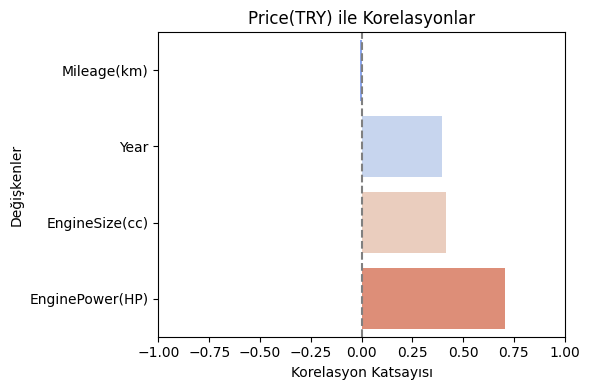

In [0]:

import matplotlib.pyplot as plt
import seaborn as sns

# Price ile diğer sayısal kolonlar arasındaki korelasyonları al
corr_series = pandas_df[["Price(TRY)", "Mileage(km)", "Year", "EngineSize(cc)", "EnginePower(HP)"]].corr()["Price(TRY)"].drop("Price(TRY)")

# Görselleştirme
plt.figure(figsize=(6, 4))
sns.barplot(x=corr_series.values, y=corr_series.index, palette="coolwarm")

plt.title("Price(TRY) ile Korelasyonlar")
plt.xlabel("Korelasyon Katsayısı")
plt.ylabel("Değişkenler")
plt.xlim(-1, 1)
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



pozitif değerler: Price arttıkça bu değişken de artma eğiliminde (örneğin EnginePower(HP)).

Negatif değerler: Price arttıkça bu değişken azalma eğiliminde (örneğin Mileage(km) olabilir).

0’a yakın değerler: Neredeyse ilişkisizdir.

<Axes: >

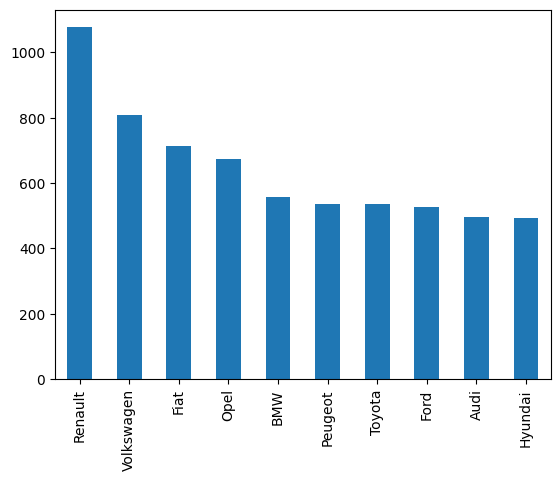

In [0]:
pandas_df['Brand'].value_counts().head(10).plot.bar()

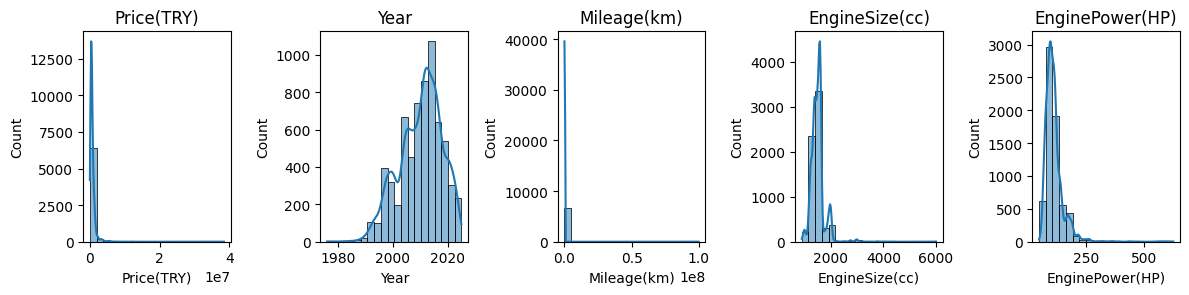

In [0]:
# Distribution of Numerical Features
numerical_features = ['Price(TRY)', 'Year', 'Mileage(km)', 'EngineSize(cc)', 'EnginePower(HP)']

plt.figure(figsize=(12, 8))
for feature in numerical_features:
    plt.subplot(3, 5, numerical_features.index(feature) + 1)
    sns.histplot(data=pandas_df[feature], bins=20, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

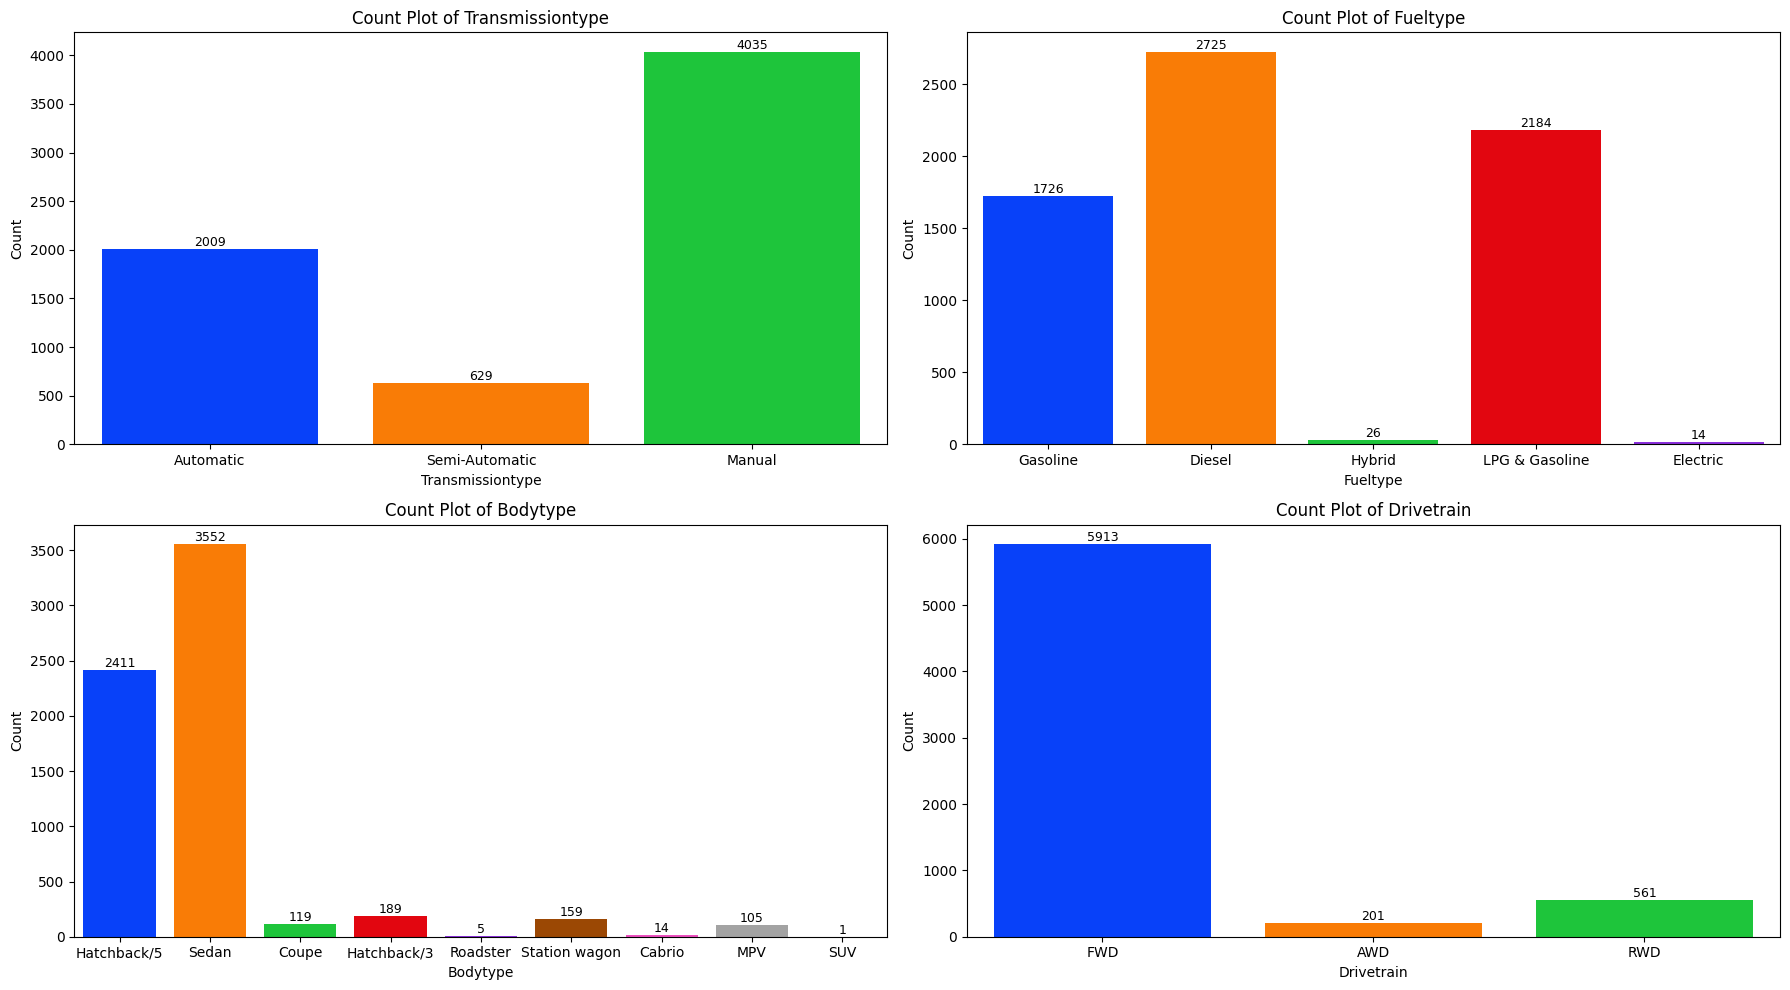

In [0]:
categorical_columns = [ 'TransmissionType',
                       'FuelType', 'BodyType', 'DriveTrain']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axes = axes.ravel()  # Flatten the 2D array of axes

# Loop through each categorical column
for i, column in enumerate(categorical_columns):
    sns.countplot(x=pandas_df[column], data=pandas_df, palette='bright', ax=axes[i], saturation=0.95)
    for container in axes[i].containers:
        axes[i].bar_label(container, color='black', size=9)
    axes[i].set_title(f'Count Plot of {column.capitalize()}')
    axes[i].set_xlabel(column.capitalize())
    axes[i].set_ylabel('Count')

# Adjust layout and show plots
plt.tight_layout()
plt.show()

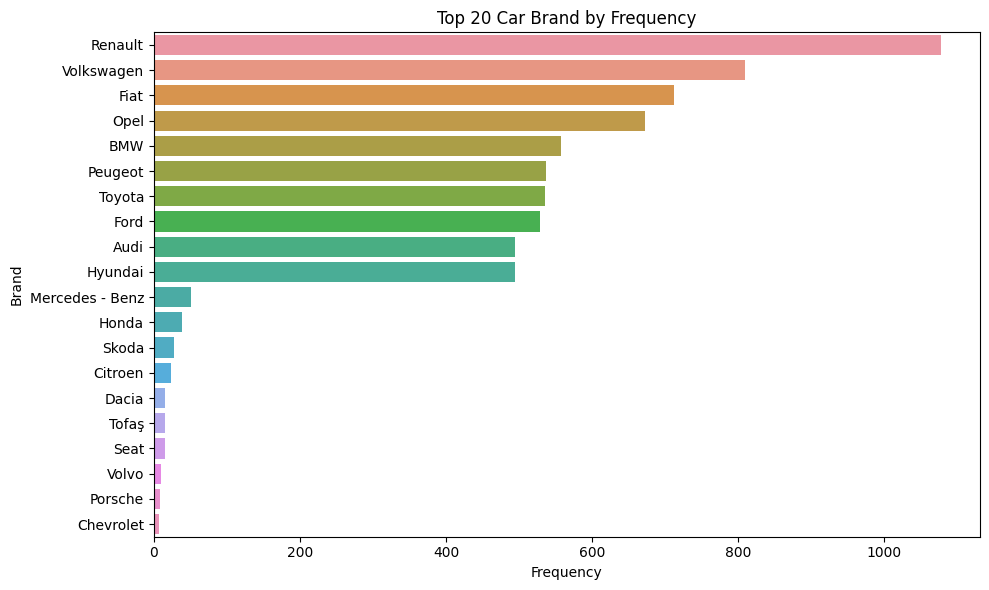

In [0]:
n = 20  # Number of top car models to plot
top_car_models = pandas_df['Brand'].value_counts().head(n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_car_models.values, y=top_car_models.index)
plt.title(f'Top {n} Car Brand by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Brand')
plt.tight_layout()
plt.show()

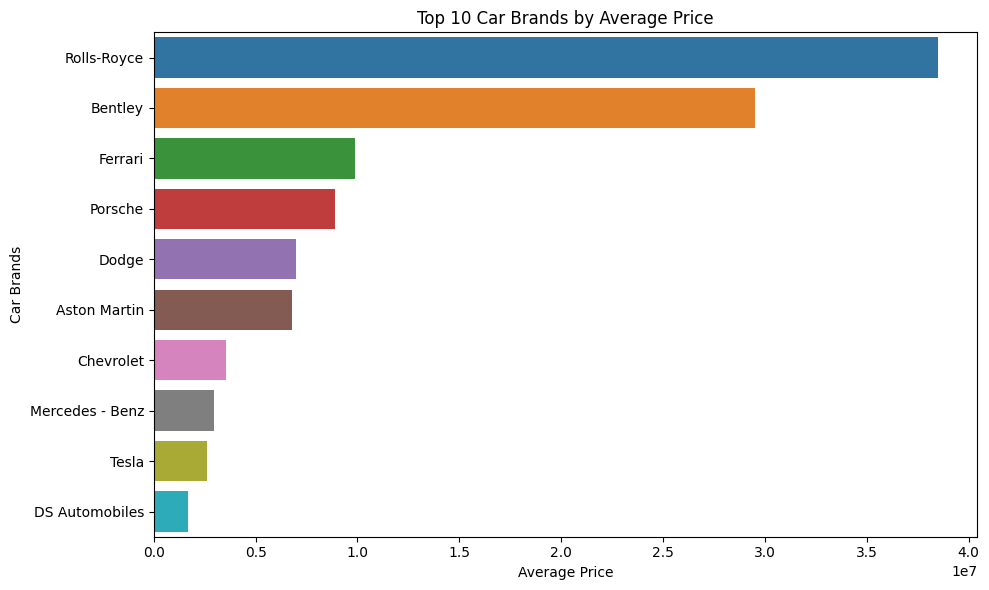

In [0]:
# Calculate average price for each car model
avg_prices_by_car = pandas_df.groupby('Brand')['Price(TRY)'].mean().sort_values(ascending=False)

# Plot top N car models by average price
n = 10  # Number of top car models to plot
top_car_models = avg_prices_by_car.head(n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_car_models.values, y=top_car_models.index)
plt.title(f'Top {n} Car Brands by Average Price')
plt.xlabel('Average Price')
plt.ylabel('Car Brands')
plt.tight_layout()
plt.show()

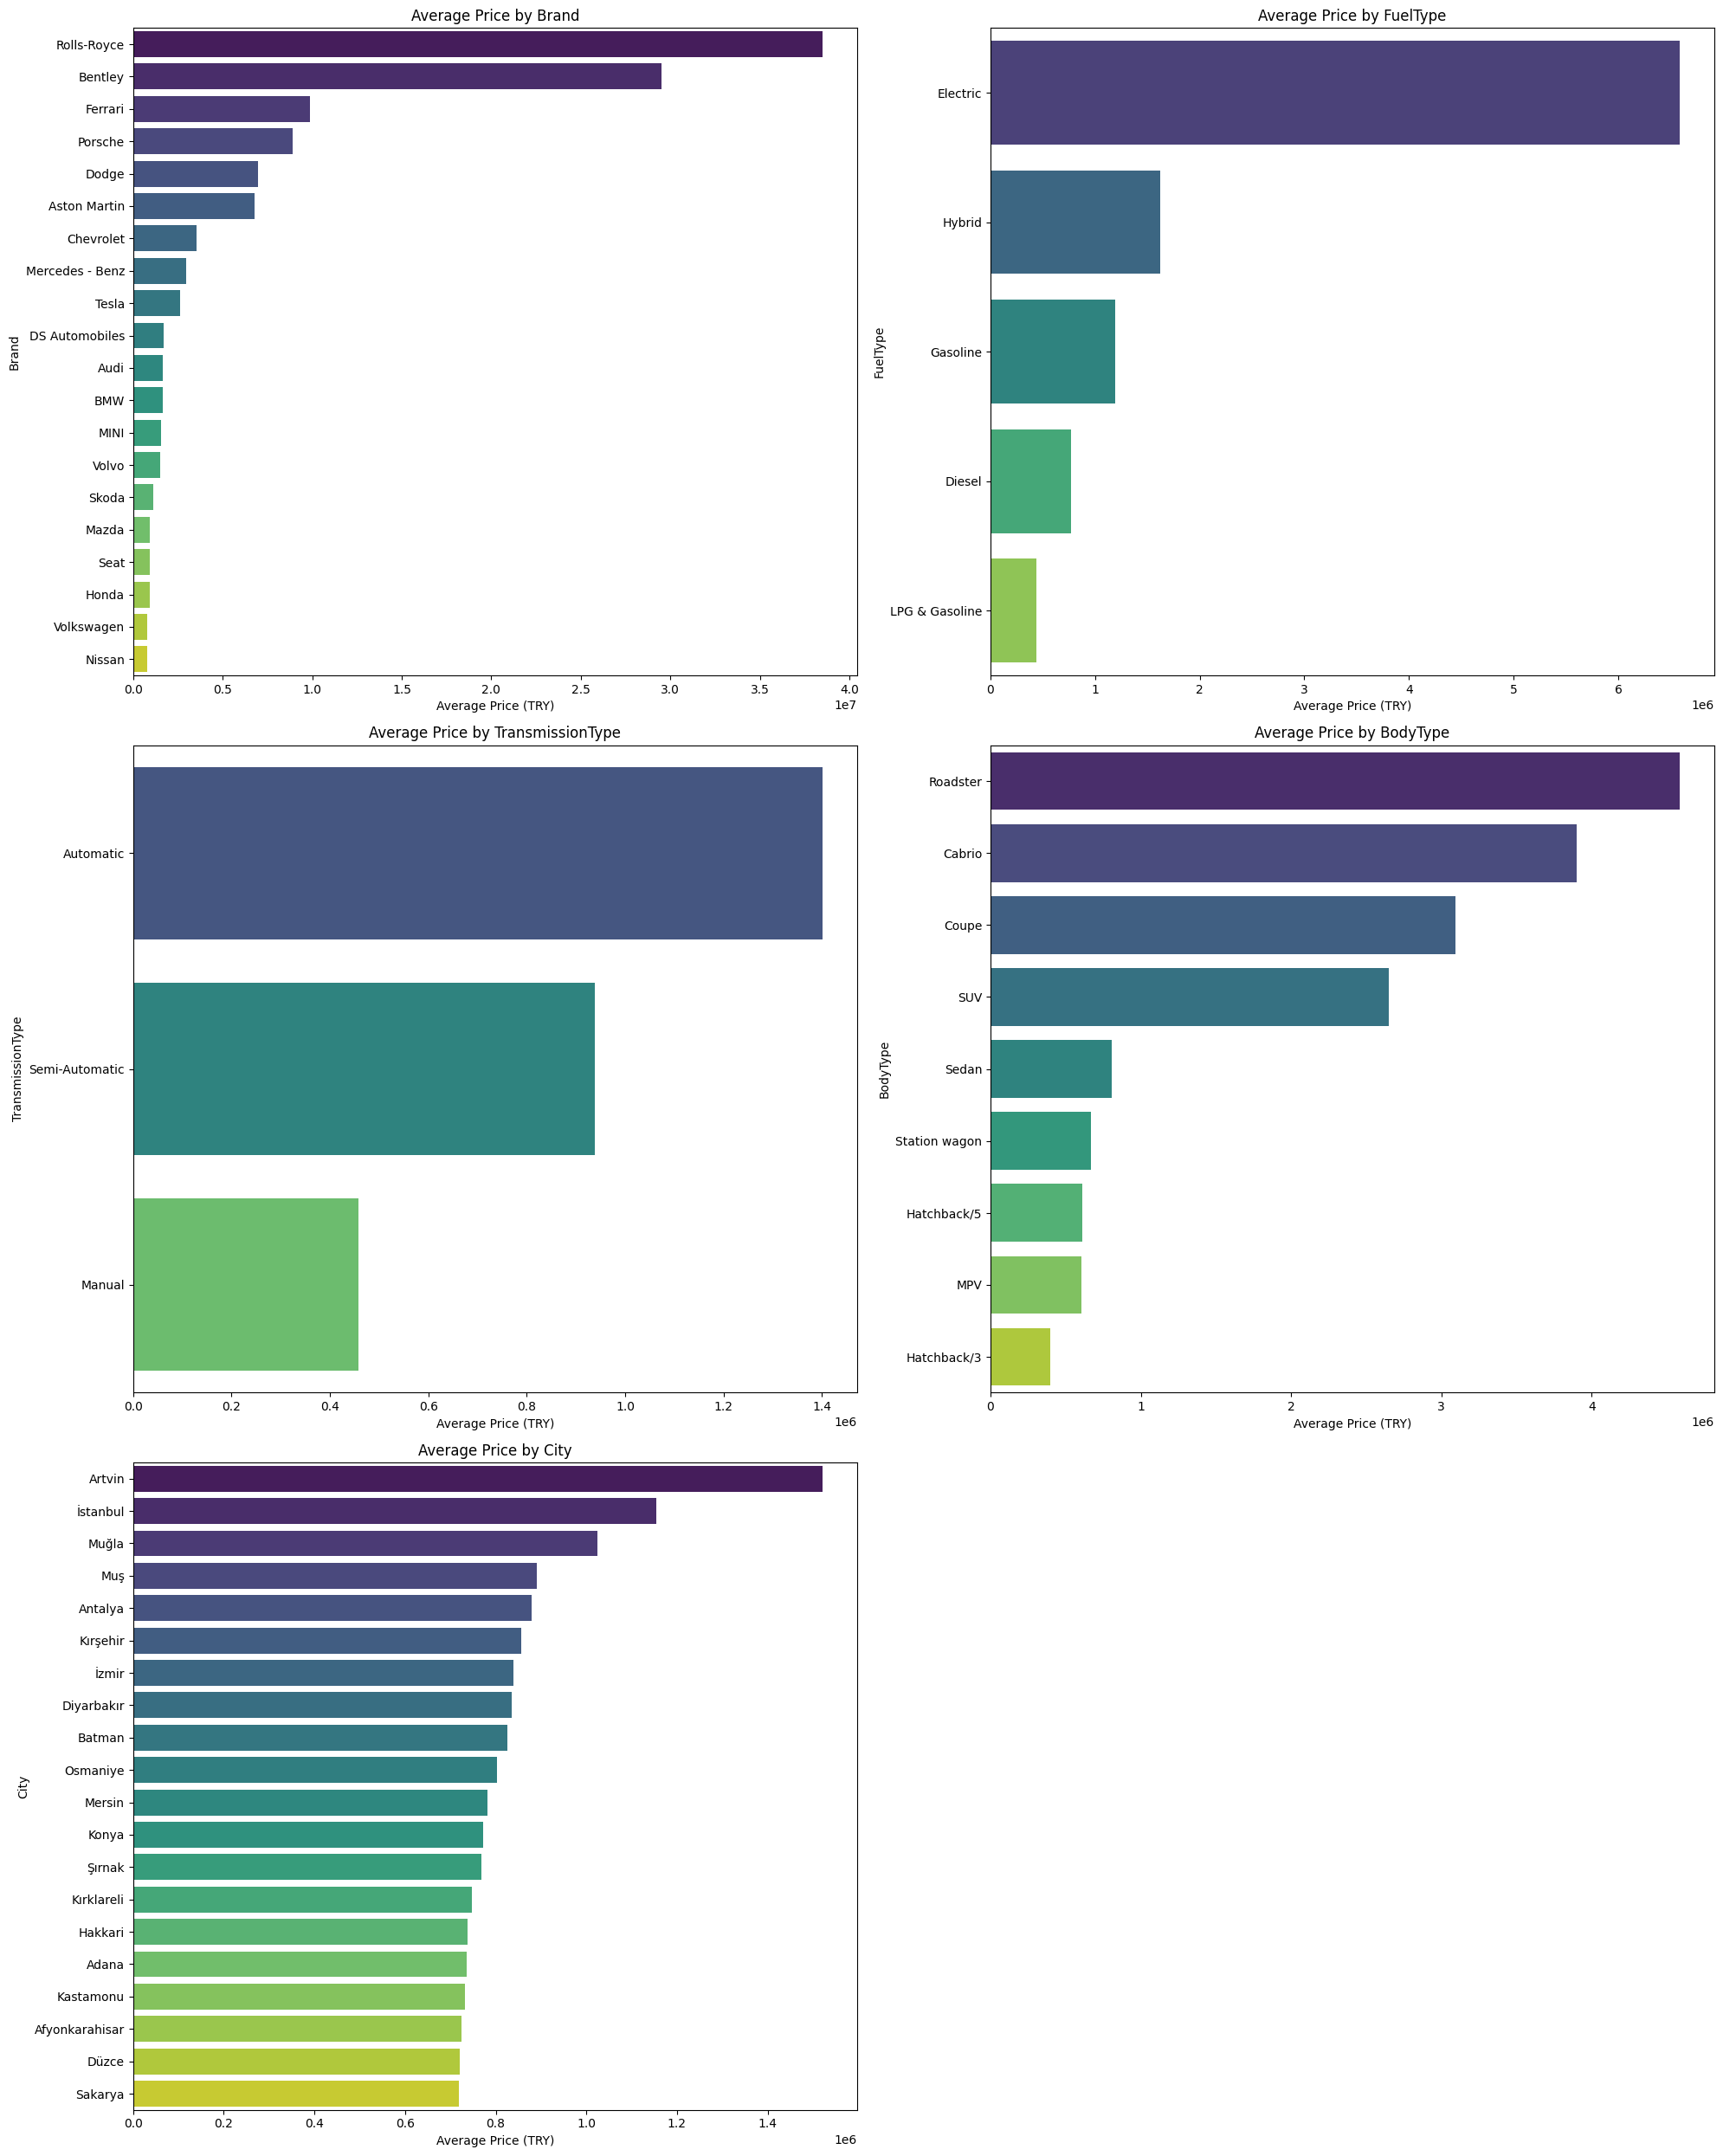

In [0]:


# Gruplanacak kategorik sütunlar
group_columns = ["Brand", "FuelType", "TransmissionType", "BodyType", "City"]

# Görsel ayarları
plt.figure(figsize=(20, 25))

for i, col in enumerate(group_columns):
    plt.subplot(3, 2, i+1)
    
    # Ortalama fiyatı hesapla
    mean_prices = pandas_df.groupby(col)["Price(TRY)"].mean().sort_values(ascending=False).head(20)
    
    # Barplot çiz
    sns.barplot(x=mean_prices.values, y=mean_prices.index, palette="viridis")
    plt.title(f"Average Price by {col}")
    plt.xlabel("Average Price (TRY)")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [0]:
#removed outliers

def remove_outliers_iqr(df):
    pandas_df_2 = pandas_df.copy()
    numerical_cols = pandas_df.select_dtypes(include=['int64', 'float64']).columns

    for col in numerical_cols:
        Q1 = pandas_df_2[col].quantile(0.25)
        Q3 = pandas_df_2[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        pandas_df_2 = pandas_df[(pandas_df[col] >= lower_bound) & (pandas_df[col] <= upper_bound)]

    return pandas_df_2


In [0]:
df_outlier_removed = remove_outliers_iqr(pandas_df)


In [0]:
print("Orijinal veri boyutu:", pandas_df.shape)
print("Outlier'lar temizlendikten sonra:", df_outlier_removed.shape)


Orijinal veri boyutu: (6675, 21)
Outlier'lar temizlendikten sonra: (6020, 21)


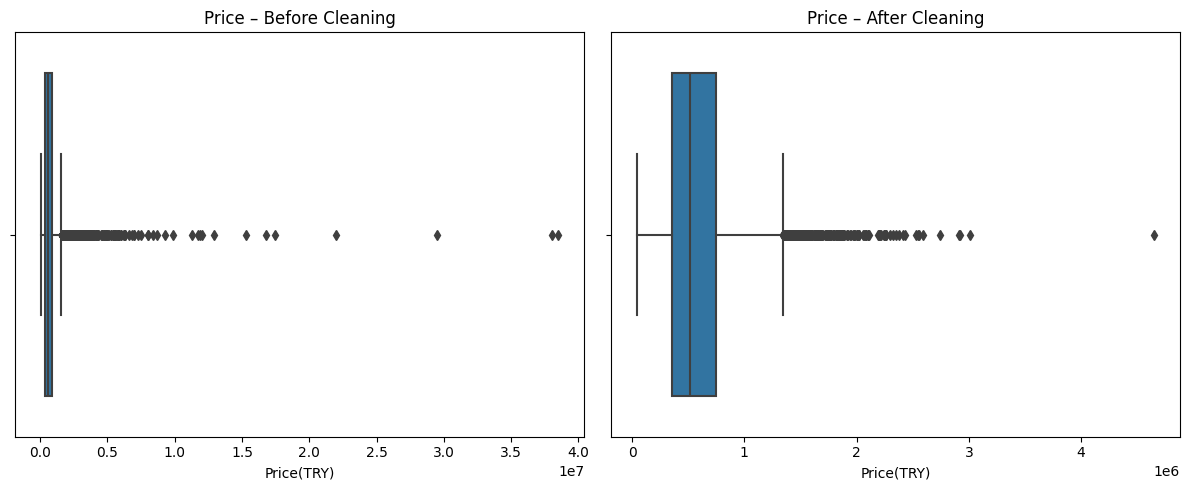

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Temizleme öncesi
plt.subplot(1, 2, 1)
sns.boxplot(x=pandas_df["Price(TRY)"])
plt.title("Price – Before Cleaning")

# Temizleme sonrası
plt.subplot(1, 2, 2)
sns.boxplot(x=df_outlier_removed["Price(TRY)"])
plt.title("Price – After Cleaning")

plt.tight_layout()
plt.show()


In [0]:
pandas_df

,ListingTitle,District,City,Price(TRY),ListingID,ListingDate,Brand,Series,Model,Year,Mileage(km),TransmissionType,FuelType,BodyType,Color,EngineSize(cc),EnginePower(HP),DriveTrain,PaintAndPartsCondition,SellerType,AccidentHistory
0,2016 AUDİ A3 SPORTBACK 1.0 TFSI BOYASIZ/DEĞİŞE...,Aşağısoku Mh. Merkez,Bolu,1169000,27812680,2025-04-07,Audi,A3,A3 Sportback 1.0 TFSI Dynamic,2016.0,120000.0,Automatic,Gasoline,Hatchback/5,White,1200.0,113.0,FWD,Original Right Rear Fender Trunk Lid Left R...,Unknown,No_Info
1,2018 AUDİ A6 2.0 TDI QUATTRO SUNROOF MATRİX VA...,Güneşevler Mh. Altındağ,Ankara,2450000,28816234,2025-04-07,Audi,A6,A6 Sedan 2.0 TDI Quattro,2018.0,136000.0,Semi-Automatic,Diesel,Sedan,Black,1968.0,190.0,AWD,Original Trunk Lid Right Rear Door Right Fr...,Dealer,Amount not specified
2,Sahibinden Audi A4 Sedan 1.8 TFSI 2011 Model,Burmalı Mh. Merkez,Afyonkarahisar,750000,28781662,2025-04-08,Audi,A4,A4 Sedan 1.8 TFSI,2011.0,285000.0,Automatic,Gasoline,Sedan,White,1798.0,160.0,FWD,Original Roof Left Front Door Hood Front B...,Private Seller,75.000
3,2016 AUDI A3 AMBİENTE *CAM TAVAN LED XENON HIZ...,Ilıca Mh. Manavgat,Antalya,1195000,28731117,2025-04-03,Audi,A3,A3 Sportback 1.6 TDI Ambiente,2016.0,101000.0,Semi-Automatic,Diesel,Hatchback/5,Black,1598.0,110.0,FWD,Original Right Rear Fender Trunk Lid Right ...,Dealer,No tram amount
4,Sahibinden Audi A3 Sportback 1.6 TDI S-Line 20...,Uğur Mumcu Mh. Yenimahalle,Ankara,822000,28393351,2025-04-02,Audi,A3,A3 Sportback 1.6 TDI Attraction,2012.0,212000.0,Semi-Automatic,Diesel,Hatchback/5,White,1598.0,105.0,FWD,Original Right Rear Fender Trunk Lid Left R...,Unknown,Amount not specified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6670,Sahibinden Opel Corsa 1.3 CDTI Enjoy 111 2010 ...,Karapürçek Mh. Altındağ,Ankara,450000,29019564,2025-04-16,Opel,Corsa,1.3 CDTI Enjoy 111,2010.0,257000.0,Manual,Diesel,Hatchback/5,Unknown,1248.0,90.0,FWD,Original Right Rear Fender Trunk Lid Left R...,Private Seller,No tram amount
6671,ÇORUM MERKEZ 1999 HONDA CİVİC 1.4is TAVAN BOYASIZ,Ak Kent Mh. Merkez,Çorum,355000,29019753,2025-04-16,Honda,Civic,1.4 i S,1999.0,304000.0,Automatic,LPG & Gasoline,Sedan,Unknown,1396.0,90.0,FWD,Original Roof Locally Painted - Painted R...,Unknown,No tram amount
6672,Sahibinden Peugeot 206 1.4 X-Design 2005 Model,Cumhuriyet Mh. Lüleburgaz,Kırklareli,375000,29018858,2025-04-16,Peugeot,206,1.4 X-Design,2005.0,208000.0,Manual,LPG & Gasoline,Hatchback/3,Unknown,1360.0,76.0,FWD,Original - Locally Painted - Painted Righ...,Private Seller,Tramer 3.000 TL
6673,Sahibinden Peugeot 206 1.6 XT 2001 Model,Batıkent Mh. Şehitkamil,Gaziantep,220000,29019438,2025-04-16,Peugeot,206,1.6 XT,2001.0,138000.0,Automatic,LPG & Gasoline,Hatchback/5,Unknown,1587.0,109.0,FWD,Original Right Rear Fender Trunk Lid Left R...,Private Seller,No_Info


In [0]:
print(pandas_df.columns.tolist())

['ListingTitle', 'District', 'City', 'Price(TRY)', 'ListingID', 'ListingDate', 'Brand', 'Series', 'Model', 'Year', 'Mileage(km)', 'TransmissionType', 'FuelType', 'BodyType', 'Color', 'EngineSize(cc)', 'EnginePower(HP)', 'DriveTrain', 'PaintAndPartsCondition', 'SellerType', 'AccidentHistory']


In [0]:
from datetime import datetime

In [0]:
 #District ---> NEW_District
pandas_df['NEW_District'] = pandas_df['District'].apply(lambda x: x.split()[-1])
pandas_df.drop('District', axis=1, inplace=True)

In [0]:
# ListingDate ---> NEW_DaysSinceListing
current_date = datetime.now()
pandas_df['NEW_DaysSinceListing'] = (current_date - pandas_df['ListingDate']).dt.days

In [0]:
# Year ---> NEW_CarAge
pandas_df['NEW_CarAge'] = (current_date.date().year - pandas_df['Year'])

In [0]:
# Mileage(km) --->  NEW_KmPerYear, NEW_KmCategory
pandas_df['NEW_KmPerYear'] = pandas_df['Mileage(km)'] / (pandas_df['NEW_CarAge'] + 1)

In [0]:
bins = [0, 50000, 100000, 150000, 200000, 300000, np.inf]
labels = ["0-50K", "50-100K", "100-150K", "150-200K", "200-300K", "300K+"]
pandas_df["NEW_KmCategory"] = pd.cut(pandas_df["Mileage(km)"], bins=bins, labels=labels)
pandas_df["NEW_KmCategory"] = pandas_df["NEW_KmCategory"].astype("O")

In [0]:

# Brand + Price(TRY) ---> NEW_AvgPricePerBrand
pandas_df['NEW_AvgPricePerBrandSeries'] = pandas_df.groupby(['Brand', 'Series'])['Price(TRY)'].transform('mean')

In [0]:
# Brand + Price(TRY) ---> NEW_AvgKmPerBrandSeries
pandas_df['NEW_AvgKmPerBrandSeries'] = pandas_df.groupby(['Brand', 'Series'])['Mileage(km)'].transform('mean')

In [0]:
# NEW_District + Price(TRY) ---> NEW_DistrictAvgPrice
pandas_df['NEW_DistrictAvgPrice'] = pandas_df.groupby('NEW_District')['Price(TRY)'].transform('mean')

In [0]:
 #PaintAndPartsCondition ---> NEW_NumOriginalParts, NEW_NumLocalPaintedParts, NEW_NumPaintedParts, NEW_NumChangedParts, NEW_NumUnknownParts
parts_list = [
    "Right Front Door", "Right Rear Door", "Left Front Door", "Left Rear Door",
    "Right Front Fender", "Left Front Fender", "Right Rear Fender", "Left Rear Fender",
    "Trunk Lid", "Hood", "Roof", "Front Bumper", "Rear Bumper"
]
def count_parts_by_category(text):
    categories = ['Original', 'Locally Painted', 'Painted', 'Replaced', 'Not Specified']
    result = dict.fromkeys([c + "_Count" for c in categories], 0)

    for i, cat in enumerate(categories):
        try:
            start = text.index(cat) + len(cat)
            end = text.index(categories[i + 1]) if i + 1 < len(categories) else len(text)
            segment = text[start:end]
            count = sum(1 for part in parts_list if part in segment)
            result[cat + "_Count"] = count
        except ValueError:
            result[cat + "_Count"] = 0

    return pd.Series(result)
pandas_df[['NEW_NumOriginalParts', 'NEW_NumLocalPaintedParts', 'NEW_NumPaintedParts', 'NEW_NumChangedParts', 'NEW_NumUnknownParts']] = pandas_df['PaintAndPartsCondition'].apply(count_parts_by_category)
pandas_df.drop('PaintAndPartsCondition', axis=1, inplace=True)

In [0]:

# AccidentHistory ---> NEW_HasDamage, NEW_HasHighDamage, NEW_DamageCost
def detect_damage(x):
    if pd.isna(x):  # Gerçek NaN
        return -1
    x = str(x).strip().lower().replace('\n', '').replace('\r', '')
    if 'No tram amount' in x or x == 'No':
        return 0
    elif 'ağır hasar' in x or any(char.isdigit() for char in x):
        return 1
    elif 'Not Specified' in x or x == '' or x == 'nan':
        return -1
    else:
        return 1  # Emin olunamayan ama boş olmayan değerler
pandas_df['NEW_HasDamage'] = pandas_df['AccidentHistory'].apply(detect_damage)

pandas_df['NEW_HasHighDamage'] = pandas_df['AccidentHistory'].apply(
    lambda x: 1 if isinstance(x, str) and 'ağır hasar' in x.lower().replace('\n', '').replace('\r', '') else 0)

def extract_cost(val):
    if isinstance(val, str):
        # Sayı içeriyorsa ayıkla
        match = re.search(r'\d[\d\.]*', val)
        if match:
            return float(match.group(0).replace('.', '').replace(',', '.'))
    return np.nan
pandas_df['NEW_DamageCost'] = pandas_df['AccidentHistory'].apply(extract_cost)
pandas_df.drop('AccidentHistory', axis=1, inplace=True)

In [0]:
pandas_df.head()

,ListingTitle,City,Price(TRY),ListingID,ListingDate,Brand,Series,Model,Year,Mileage(km),TransmissionType,FuelType,BodyType,Color,EngineSize(cc),EnginePower(HP),DriveTrain,SellerType,NEW_District,NEW_DaysSinceListing,NEW_CarAge,NEW_KmPerYear,NEW_KmCategory,NEW_AvgPricePerBrandSeries,NEW_AvgKmPerBrandSeries,NEW_DistrictAvgPrice,NEW_NumOriginalParts,NEW_NumLocalPaintedParts,NEW_NumPaintedParts,NEW_NumChangedParts,NEW_NumUnknownParts,NEW_HasDamage,NEW_HasHighDamage,NEW_DamageCost
0,2016 AUDİ A3 SPORTBACK 1.0 TFSI BOYASIZ/DEĞİŞE...,Bolu,1169000,27812680,2025-04-07,Audi,A3,A3 Sportback 1.0 TFSI Dynamic,2016.0,120000.0,Automatic,Gasoline,Hatchback/5,White,1200.0,113.0,FWD,Unknown,Merkez,44,9.0,12000.000000,100-150K,1.166780e+06,161224.075893,639596.317662,13,0,0,0,0,1,0,NaN
1,2018 AUDİ A6 2.0 TDI QUATTRO SUNROOF MATRİX VA...,Ankara,2450000,28816234,2025-04-07,Audi,A6,A6 Sedan 2.0 TDI Quattro,2018.0,136000.0,Semi-Automatic,Diesel,Sedan,Black,1968.0,190.0,AWD,Dealer,Altındağ,44,7.0,17000.000000,100-150K,2.131899e+06,228153.204082,615934.150000,8,0,4,1,0,1,0,NaN
2,Sahibinden Audi A4 Sedan 1.8 TFSI 2011 Model,Afyonkarahisar,750000,28781662,2025-04-08,Audi,A4,A4 Sedan 1.8 TFSI,2011.0,285000.0,Automatic,Gasoline,Sedan,White,1798.0,160.0,FWD,Private Seller,Merkez,43,14.0,19000.000000,200-300K,1.331756e+06,209684.351351,639596.317662,5,0,8,0,0,1,0,75000.0
3,2016 AUDI A3 AMBİENTE *CAM TAVAN LED XENON HIZ...,Antalya,1195000,28731117,2025-04-03,Audi,A3,A3 Sportback 1.6 TDI Ambiente,2016.0,101000.0,Semi-Automatic,Diesel,Hatchback/5,Black,1598.0,110.0,FWD,Dealer,Manavgat,48,9.0,10100.000000,100-150K,1.166780e+06,161224.075893,940699.962963,11,0,1,1,0,1,0,NaN
4,Sahibinden Audi A3 Sportback 1.6 TDI S-Line 20...,Ankara,822000,28393351,2025-04-02,Audi,A3,A3 Sportback 1.6 TDI Attraction,2012.0,212000.0,Semi-Automatic,Diesel,Hatchback/5,White,1598.0,105.0,FWD,Unknown,Yenimahalle,49,13.0,15142.857143,200-300K,1.166780e+06,161224.075893,791699.214286,12,0,1,0,0,1,0,NaN


In [0]:
pandas_df.isna().sum()

ListingTitle                     0
City                             0
Price(TRY)                       0
ListingID                        0
ListingDate                      0
Brand                            0
Series                           0
Model                            1
Year                             1
Mileage(km)                      2
TransmissionType                 2
FuelType                         0
BodyType                       120
Color                            0
EngineSize(cc)                   0
EnginePower(HP)                  0
DriveTrain                       0
SellerType                       0
NEW_District                     0
NEW_DaysSinceListing             0
NEW_CarAge                       1
NEW_KmPerYear                    2
NEW_KmCategory                   3
NEW_AvgPricePerBrandSeries       0
NEW_AvgKmPerBrandSeries          2
NEW_DistrictAvgPrice             0
NEW_NumOriginalParts             0
NEW_NumLocalPaintedParts         0
NEW_NumPaintedParts 

In [0]:
# NEW_DamageCost
pandas_df.loc[pandas_df['NEW_HasDamage'] == 1, 'NEW_DamageCost'].fillna(
    pandas_df[pandas_df['NEW_HasDamage'] == 1].groupby(['Brand', 'Series', 'Year', 'EngineSize(cc)'])['NEW_DamageCost'].transform('mean'), inplace=True)

pandas_df.loc[(pandas_df['NEW_HasDamage'] == 0) & (pandas_df['NEW_DamageCost'].isna()), 'NEW_DamageCost'] = 0

pandas_df.loc[(pandas_df['NEW_HasDamage'] == -1) & (pandas_df['NEW_DamageCost'].isna()), 'NEW_DamageCost'] = pandas_df['NEW_DamageCost'].mean()

pandas_df['NEW_DamageCost'].fillna(pandas_df['NEW_DamageCost'].median(), inplace=True)
pandas_df.dropna(inplace=True)

In [0]:
pandas_df

,ListingTitle,City,Price(TRY),ListingID,ListingDate,Brand,Series,Model,Year,Mileage(km),TransmissionType,FuelType,BodyType,Color,EngineSize(cc),EnginePower(HP),DriveTrain,SellerType,NEW_District,NEW_DaysSinceListing,NEW_CarAge,NEW_KmPerYear,NEW_KmCategory,NEW_AvgPricePerBrandSeries,NEW_AvgKmPerBrandSeries,NEW_DistrictAvgPrice,NEW_NumOriginalParts,NEW_NumLocalPaintedParts,NEW_NumPaintedParts,NEW_NumChangedParts,NEW_NumUnknownParts,NEW_HasDamage,NEW_HasHighDamage,NEW_DamageCost
0,2016 AUDİ A3 SPORTBACK 1.0 TFSI BOYASIZ/DEĞİŞE...,Bolu,1169000,27812680,2025-04-07,Audi,A3,A3 Sportback 1.0 TFSI Dynamic,2016.0,120000.0,Automatic,Gasoline,Hatchback/5,White,1200.0,113.0,FWD,Unknown,Merkez,44,9.0,12000.000000,100-150K,1.166780e+06,161224.075893,639596.317662,13,0,0,0,0,1,0,7000.0
1,2018 AUDİ A6 2.0 TDI QUATTRO SUNROOF MATRİX VA...,Ankara,2450000,28816234,2025-04-07,Audi,A6,A6 Sedan 2.0 TDI Quattro,2018.0,136000.0,Semi-Automatic,Diesel,Sedan,Black,1968.0,190.0,AWD,Dealer,Altındağ,44,7.0,17000.000000,100-150K,2.131899e+06,228153.204082,615934.150000,8,0,4,1,0,1,0,7000.0
2,Sahibinden Audi A4 Sedan 1.8 TFSI 2011 Model,Afyonkarahisar,750000,28781662,2025-04-08,Audi,A4,A4 Sedan 1.8 TFSI,2011.0,285000.0,Automatic,Gasoline,Sedan,White,1798.0,160.0,FWD,Private Seller,Merkez,43,14.0,19000.000000,200-300K,1.331756e+06,209684.351351,639596.317662,5,0,8,0,0,1,0,75000.0
3,2016 AUDI A3 AMBİENTE *CAM TAVAN LED XENON HIZ...,Antalya,1195000,28731117,2025-04-03,Audi,A3,A3 Sportback 1.6 TDI Ambiente,2016.0,101000.0,Semi-Automatic,Diesel,Hatchback/5,Black,1598.0,110.0,FWD,Dealer,Manavgat,48,9.0,10100.000000,100-150K,1.166780e+06,161224.075893,940699.962963,11,0,1,1,0,1,0,7000.0
4,Sahibinden Audi A3 Sportback 1.6 TDI S-Line 20...,Ankara,822000,28393351,2025-04-02,Audi,A3,A3 Sportback 1.6 TDI Attraction,2012.0,212000.0,Semi-Automatic,Diesel,Hatchback/5,White,1598.0,105.0,FWD,Unknown,Yenimahalle,49,13.0,15142.857143,200-300K,1.166780e+06,161224.075893,791699.214286,12,0,1,0,0,1,0,7000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6670,Sahibinden Opel Corsa 1.3 CDTI Enjoy 111 2010 ...,Ankara,450000,29019564,2025-04-16,Opel,Corsa,1.3 CDTI Enjoy 111,2010.0,257000.0,Manual,Diesel,Hatchback/5,Unknown,1248.0,90.0,FWD,Private Seller,Altındağ,35,15.0,16062.500000,200-300K,4.877578e+05,190650.376884,615934.150000,13,0,0,0,0,1,0,7000.0
6671,ÇORUM MERKEZ 1999 HONDA CİVİC 1.4is TAVAN BOYASIZ,Çorum,355000,29019753,2025-04-16,Honda,Civic,1.4 i S,1999.0,304000.0,Automatic,LPG & Gasoline,Sedan,Unknown,1396.0,90.0,FWD,Unknown,Merkez,35,26.0,11259.259259,300K+,9.208712e+05,177728.787879,639596.317662,1,0,8,2,2,1,0,7000.0
6672,Sahibinden Peugeot 206 1.4 X-Design 2005 Model,Kırklareli,375000,29018858,2025-04-16,Peugeot,206,1.4 X-Design,2005.0,208000.0,Manual,LPG & Gasoline,Hatchback/3,Unknown,1360.0,76.0,FWD,Private Seller,Lüleburgaz,35,20.0,9904.761905,200-300K,3.051477e+05,237324.908163,946083.250000,0,0,5,1,7,1,0,3000.0
6673,Sahibinden Peugeot 206 1.6 XT 2001 Model,Gaziantep,220000,29019438,2025-04-16,Peugeot,206,1.6 XT,2001.0,138000.0,Automatic,LPG & Gasoline,Hatchback/5,Unknown,1587.0,109.0,FWD,Private Seller,Şehitkamil,35,24.0,5520.000000,100-150K,3.051477e+05,237324.908163,846367.905660,13,0,0,0,0,1,0,7000.0


One-Hot Encoding → Az kategorili sütunlar

Rare Encoding → Çok kategorili sütunlarda seyrekleri grupla

Frequency Encoding → Rare edilmiş sütunlara sıklık oranı ata

In [0]:
import pandas as pd

# --- Rare Encoder ---
def rare_encoder(dataframe, column, threshold=0.02):
    value_counts = dataframe[column].value_counts(normalize=True)
    rare_labels = value_counts[value_counts < threshold].index
    dataframe[column] = dataframe[column].apply(lambda x: 'Rare' if x in rare_labels else x)
    return dataframe

# --- Frequency Encoder ---
def frequency_encoder(dataframe, column):
    freq = dataframe[column].value_counts(normalize=True)
    dataframe[column] = dataframe[column].map(freq)
    return dataframe

# --- One-Hot Encoder ---
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

# --- Full Encoding Pipeline ---
def encode_dataframe(df, rare_thresh=0.02):
    df = df.copy()
    
    # 1. Kategorik sütunları seç
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    one_hot_cols = []
    rare_freq_cols = []

    for col in categorical_cols:
        if df[col].nunique() < 15:
            one_hot_cols.append(col)
        else:
            rare_freq_cols.append(col)

    # 2. One-Hot Encoding
    df = one_hot_encoder(df, one_hot_cols)

    # 3. Rare + Frequency Encoding
    for col in rare_freq_cols:
        df = rare_encoder(df, col, threshold=rare_thresh)
        df = frequency_encoder(df, col)

    return df


In [0]:
df_encoded = encode_dataframe(pandas_df)

In [0]:
df_encoded

,ListingTitle,City,Price(TRY),ListingID,ListingDate,Brand,Series,Model,Year,Mileage(km),Color,EngineSize(cc),EnginePower(HP),NEW_District,NEW_DaysSinceListing,NEW_CarAge,NEW_KmPerYear,NEW_AvgPricePerBrandSeries,NEW_AvgKmPerBrandSeries,NEW_DistrictAvgPrice,NEW_NumOriginalParts,NEW_NumLocalPaintedParts,NEW_NumPaintedParts,NEW_NumChangedParts,NEW_NumUnknownParts,NEW_HasDamage,NEW_HasHighDamage,NEW_DamageCost,TransmissionType_Manual,TransmissionType_Semi-Automatic,FuelType_Electric,FuelType_Gasoline,FuelType_Hybrid,FuelType_LPG & Gasoline,BodyType_Coupe,BodyType_Hatchback/3,BodyType_Hatchback/5,BodyType_MPV,BodyType_Roadster,BodyType_SUV,BodyType_Sedan,BodyType_Station wagon,DriveTrain_FWD,DriveTrain_RWD,SellerType_Dealer,SellerType_Private Seller,SellerType_Unknown,NEW_KmCategory_100-150K,NEW_KmCategory_150-200K,NEW_KmCategory_200-300K,NEW_KmCategory_300K+,NEW_KmCategory_50-100K
0,1.0,0.385472,1169000,27812680,2025-04-07,0.074775,0.034030,1.0,2016.0,120000.0,0.220204,1200.0,113.0,0.118877,44,9.0,12000.000000,1.166780e+06,161224.075893,639596.317662,13,0,0,0,0,1,0,7000.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
1,1.0,0.112620,2450000,28816234,2025-04-07,0.074775,0.465588,1.0,2018.0,136000.0,0.075843,1968.0,190.0,0.858233,44,7.0,17000.000000,2.131899e+06,228153.204082,615934.150000,8,0,4,1,0,1,0,7000.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
2,1.0,0.385472,750000,28781662,2025-04-08,0.074775,0.465588,1.0,2011.0,285000.0,0.220204,1798.0,160.0,0.118877,43,14.0,19000.000000,1.331756e+06,209684.351351,639596.317662,5,0,8,0,0,1,0,75000.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0
3,1.0,0.031283,1195000,28731117,2025-04-03,0.074775,0.034030,1.0,2016.0,101000.0,0.075843,1598.0,110.0,0.858233,48,9.0,10100.000000,1.166780e+06,161224.075893,940699.962963,11,0,1,1,0,1,0,7000.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
4,1.0,0.112620,822000,28393351,2025-04-02,0.074775,0.034030,1.0,2012.0,212000.0,0.220204,1598.0,105.0,0.858233,49,13.0,15142.857143,1.166780e+06,161224.075893,791699.214286,12,0,1,0,0,1,0,7000.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6670,1.0,0.112620,450000,29019564,2025-04-16,0.101785,0.029757,1.0,2010.0,257000.0,0.357699,1248.0,90.0,0.858233,35,15.0,16062.500000,4.877578e+05,190650.376884,615934.150000,13,0,0,0,0,1,0,7000.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
6671,1.0,0.385472,355000,29019753,2025-04-16,0.034488,0.465588,1.0,1999.0,304000.0,0.357699,1396.0,90.0,0.118877,35,26.0,11259.259259,9.208712e+05,177728.787879,639596.317662,1,0,8,2,2,1,0,7000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
6672,1.0,0.385472,375000,29018858,2025-04-16,0.081184,0.465588,1.0,2005.0,208000.0,0.357699,1360.0,76.0,0.858233,35,20.0,9904.761905,3.051477e+05,237324.908163,946083.250000,0,0,5,1,7,1,0,3000.0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
6673,1.0,0.036472,220000,29019438,2025-04-16,0.081184,0.465588,1.0,2001.0,138000.0,0.357699,1587.0,109.0,0.858233,35,24.0,5520.000000,3.051477e+05,237324.908163,846367.905660,13,0,0,0,0,1,0,7000.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0


In [0]:
df_encoded["Price(TRY)"] = pandas_df["Price(TRY)"].values
df_encoded["Price(TRY)_log"] = np.log1p(df_encoded["Price(TRY)"])


In [0]:
df_encoded.drop(['ListingDate', 'Price(TRY)','ListingID','ListingTitle'], axis=1, inplace=True)

In [0]:
df_encoded

,City,Brand,Series,Model,Year,Mileage(km),Color,EngineSize(cc),EnginePower(HP),NEW_District,NEW_DaysSinceListing,NEW_CarAge,NEW_KmPerYear,NEW_AvgPricePerBrandSeries,NEW_AvgKmPerBrandSeries,NEW_DistrictAvgPrice,NEW_NumOriginalParts,NEW_NumLocalPaintedParts,NEW_NumPaintedParts,NEW_NumChangedParts,NEW_NumUnknownParts,NEW_HasDamage,NEW_HasHighDamage,NEW_DamageCost,TransmissionType_Manual,TransmissionType_Semi-Automatic,FuelType_Electric,FuelType_Gasoline,FuelType_Hybrid,FuelType_LPG & Gasoline,BodyType_Coupe,BodyType_Hatchback/3,BodyType_Hatchback/5,BodyType_MPV,BodyType_Roadster,BodyType_SUV,BodyType_Sedan,BodyType_Station wagon,DriveTrain_FWD,DriveTrain_RWD,SellerType_Dealer,SellerType_Private Seller,SellerType_Unknown,NEW_KmCategory_100-150K,NEW_KmCategory_150-200K,NEW_KmCategory_200-300K,NEW_KmCategory_300K+,NEW_KmCategory_50-100K,Price(TRY)_log
0,0.385472,0.074775,0.034030,1.0,2016.0,120000.0,0.220204,1200.0,113.0,0.118877,44,9.0,12000.000000,1.166780e+06,161224.075893,639596.317662,13,0,0,0,0,1,0,7000.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,13.971660
1,0.112620,0.074775,0.465588,1.0,2018.0,136000.0,0.075843,1968.0,190.0,0.858233,44,7.0,17000.000000,2.131899e+06,228153.204082,615934.150000,8,0,4,1,0,1,0,7000.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,14.711599
2,0.385472,0.074775,0.465588,1.0,2011.0,285000.0,0.220204,1798.0,160.0,0.118877,43,14.0,19000.000000,1.331756e+06,209684.351351,639596.317662,5,0,8,0,0,1,0,75000.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,13.527830
3,0.031283,0.074775,0.034030,1.0,2016.0,101000.0,0.075843,1598.0,110.0,0.858233,48,9.0,10100.000000,1.166780e+06,161224.075893,940699.962963,11,0,1,1,0,1,0,7000.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,13.993658
4,0.112620,0.074775,0.034030,1.0,2012.0,212000.0,0.220204,1598.0,105.0,0.858233,49,13.0,15142.857143,1.166780e+06,161224.075893,791699.214286,12,0,1,0,0,1,0,7000.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,13.619497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6670,0.112620,0.101785,0.029757,1.0,2010.0,257000.0,0.357699,1248.0,90.0,0.858233,35,15.0,16062.500000,4.877578e+05,190650.376884,615934.150000,13,0,0,0,0,1,0,7000.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,13.017005
6671,0.385472,0.034488,0.465588,1.0,1999.0,304000.0,0.357699,1396.0,90.0,0.118877,35,26.0,11259.259259,9.208712e+05,177728.787879,639596.317662,1,0,8,2,2,1,0,7000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,12.779876
6672,0.385472,0.081184,0.465588,1.0,2005.0,208000.0,0.357699,1360.0,76.0,0.858233,35,20.0,9904.761905,3.051477e+05,237324.908163,946083.250000,0,0,5,1,7,1,0,3000.0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,12.834684
6673,0.036472,0.081184,0.465588,1.0,2001.0,138000.0,0.357699,1587.0,109.0,0.858233,35,24.0,5520.000000,3.051477e+05,237324.908163,846367.905660,13,0,0,0,0,1,0,7000.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,12.301387


In [0]:
from sklearn.preprocessing import StandardScaler

# 1. Scale edilecek sütunları belirle
columns_to_scale = [
     "Mileage(km)", "EngineSize(cc)", "EnginePower(HP)",
    "NEW_CarAge", "NEW_KmPerYear", "NEW_AvgPricePerBrandSeries",
    "NEW_AvgKmPerBrandSeries", "NEW_DistrictAvgPrice", "NEW_DamageCost"
]

# 2. Sütunlar gerçekten var mı kontrol et
columns_to_scale = [col for col in columns_to_scale if col in df_encoded.columns]

# 3. Scale işlemi
scaler = StandardScaler()
#df_scaled = df.select("*")
df_encoded[columns_to_scale] = scaler.fit_transform(df_encoded[columns_to_scale])


In [0]:
df_encoded

,City,Brand,Series,Model,Year,Mileage(km),Color,EngineSize(cc),EnginePower(HP),NEW_District,NEW_DaysSinceListing,NEW_CarAge,NEW_KmPerYear,NEW_AvgPricePerBrandSeries,NEW_AvgKmPerBrandSeries,NEW_DistrictAvgPrice,NEW_NumOriginalParts,NEW_NumLocalPaintedParts,NEW_NumPaintedParts,NEW_NumChangedParts,NEW_NumUnknownParts,NEW_HasDamage,NEW_HasHighDamage,NEW_DamageCost,TransmissionType_Manual,TransmissionType_Semi-Automatic,FuelType_Electric,FuelType_Gasoline,FuelType_Hybrid,FuelType_LPG & Gasoline,BodyType_Coupe,BodyType_Hatchback/3,BodyType_Hatchback/5,BodyType_MPV,BodyType_Roadster,BodyType_SUV,BodyType_Sedan,BodyType_Station wagon,DriveTrain_FWD,DriveTrain_RWD,SellerType_Dealer,SellerType_Private Seller,SellerType_Unknown,NEW_KmCategory_100-150K,NEW_KmCategory_150-200K,NEW_KmCategory_200-300K,NEW_KmCategory_300K+,NEW_KmCategory_50-100K,Price(TRY)_log
0,0.385472,0.074775,0.034030,1.0,2016.0,-0.808988,0.220204,-1.099418,0.088278,0.118877,44,-0.775457,-0.255847,0.402631,-0.948974,-0.279354,13,0,0,0,0,1,0,-0.021390,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,13.971660
1,0.112620,0.074775,0.465588,1.0,2018.0,-0.653203,0.075843,1.628867,1.941039,0.858233,44,-1.035191,0.487640,1.388100,0.582264,-0.329614,8,0,4,1,0,1,0,-0.021390,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,14.711599
2,0.385472,0.074775,0.465588,1.0,2011.0,0.797550,0.220204,1.024949,1.219184,0.118877,43,-0.126121,0.785035,0.571086,0.159724,-0.279354,5,0,8,0,0,1,0,0.204852,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,13.527830
3,0.031283,0.074775,0.034030,1.0,2016.0,-0.993984,0.075843,0.314459,0.016092,0.858233,48,-0.775457,-0.538372,0.402631,-0.948974,0.360221,11,0,1,1,0,1,0,-0.021390,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,13.993658
4,0.112620,0.074775,0.034030,1.0,2012.0,0.086778,0.220204,0.314459,-0.104217,0.858233,49,-0.255989,0.211488,0.402631,-0.948974,0.043728,12,0,1,0,0,1,0,-0.021390,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,13.619497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6670,0.112620,0.101785,0.029757,1.0,2010.0,0.524925,0.357699,-0.928900,-0.465145,0.858233,35,0.003746,0.348236,-0.290709,-0.275744,-0.329614,13,0,0,0,0,1,0,-0.021390,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,13.017005
6671,0.385472,0.034488,0.465588,1.0,1999.0,0.982545,0.357699,-0.403137,-0.465145,0.118877,35,1.432284,-0.365993,0.151537,-0.571371,-0.279354,1,0,8,2,2,1,0,-0.021390,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,12.779876
6672,0.385472,0.081184,0.465588,1.0,2005.0,0.047832,0.357699,-0.531025,-0.802010,0.858233,35,0.653081,-0.567404,-0.477169,0.792099,0.371655,0,0,5,1,7,1,0,-0.034698,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,12.834684
6673,0.036472,0.081184,0.465588,1.0,2001.0,-0.633730,0.357699,0.275382,-0.007970,0.858233,35,1.172549,-1.219407,-0.477169,0.792099,0.159850,13,0,0,0,0,1,0,-0.021390,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,12.301387


In [0]:
%pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/42/86/dabda8fbcb1b00bcfb0003c3776e8ade1aa7b413dff0a2c08f457dace22f/lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.6 MB ? eta -:--:--
   ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/3.6 MB 5.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━ 2.8/3.6 MB 40.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 3.6/3.6 MB 46.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 32.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/e2/47/abee19aae4b2a2a21e40e3c09db784099d189b3a0745e59c1d152700d90a/catboost-1.2.8-cp311-cp311-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/99.2 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/99.2 MB 7.7 MB/s eta 0:00:13
   ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/99.2 MB 50.9 MB/s eta 0:00:02
   ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/99.2 MB 73.6 MB/s eta 0:00:02
   ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/99.2 MB 107.1 MB/s eta 0:00:01
   ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/99.2 MB 112.0 MB/s eta 0:00:01
   ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/99.2 MB 110.0 MB/s eta 0:00:01
   ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━

In [0]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd

def compare_models(X, y, random_state=42, cv=5):
    models = {
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=random_state),
        "CatBoost": CatBoostRegressor(verbose=False, random_state=random_state)
    }

    results = []

    for name, model in models.items():
        scores = cross_validate(
            model, X, y,
            scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
            cv=cv,
            return_train_score=False
        )

        mae = -scores['test_neg_mean_absolute_error'].mean()
        rmse = np.sqrt(-scores['test_neg_mean_squared_error'].mean())
        r2 = scores['test_r2'].mean()

        results.append({
            'Model': name,
            'R2 Score': round(r2, 4),
            'Log RMSE': round(rmse, 2),
            'MAE': round(mae, 2)
        })

    results_df = pd.DataFrame(results).sort_values("R2 Score", ascending=False).reset_index(drop=True)
    results_df['Real RMSE'] = np.expm1(results_df['Log RMSE'])  # log dönüşümden geri dönüş
    return results_df 


In [0]:
# Hedef ve özellikleri tekrar hatırlatalım:
X = df_encoded.drop(["Price(TRY)_log"], axis=1)
y = df_encoded["Price(TRY)_log"]

results = compare_models(X, y)
print(results)



               Model  R2 Score  Log RMSE   MAE  Real RMSE
0           CatBoost    0.9216      0.16  0.11   0.173511
1  Gradient Boosting    0.9091      0.18  0.12   0.197217


In [0]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(verbose=False, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Test R² Score:", r2_score(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))


Test R² Score: 0.940565299643495
Test RMSE: 0.16207958530651964
Test MAE: 0.09593403749224823


In [0]:
from sklearn.model_selection import GridSearchCV

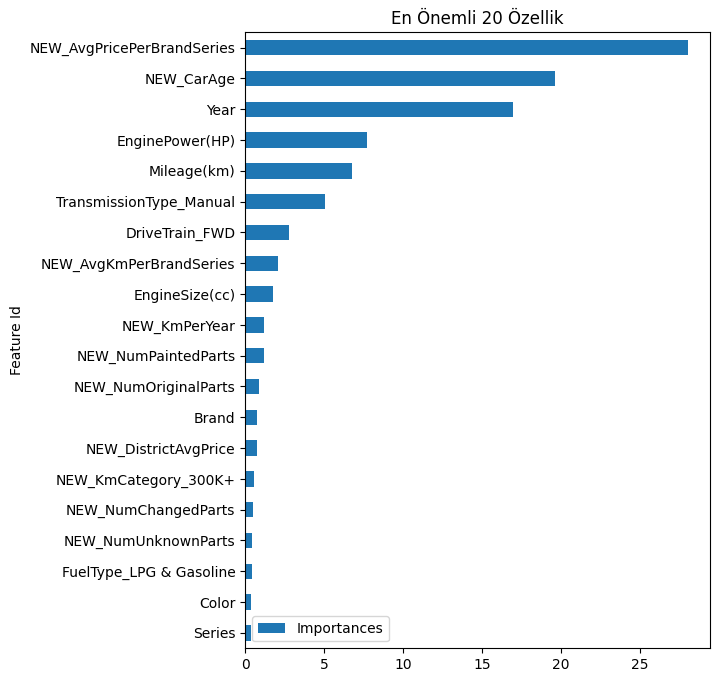

In [0]:
import matplotlib.pyplot as plt

feat_importances = model.get_feature_importance(prettified=True)
feat_importances[:20].plot(kind='barh', x='Feature Id', y='Importances', figsize=(6,8), title="En Önemli 20 Özellik")
plt.gca().invert_yaxis()
plt.show()


In [0]:
comparison = pd.DataFrame({
    "Gerçek Fiyat (log)": y_test,
    "Tahmin (log)": y_pred,
    "Gerçek Fiyat (TRY)": np.expm1(y_test),
    "Tahmin (TRY)": np.expm1(y_pred),
})
comparison

,Gerçek Fiyat (log),Tahmin (log),Gerçek Fiyat (TRY),Tahmin (TRY)
1194,13.208543,13.260629,545000.0,5.741393e+05
762,13.017005,12.818679,450000.0,3.690458e+05
3896,12.847929,12.930124,380000.0,4.125536e+05
770,14.085538,14.060481,1310000.0,1.277582e+06
5912,13.661778,13.820541,857500.0,1.005042e+06
...,...,...,...,...
3331,13.407544,13.375775,665000.0,6.442055e+05
3249,12.793862,12.701889,360000.0,3.283665e+05
1957,12.367345,12.425591,235000.0,2.490944e+05
3765,12.301387,12.224812,220000.0,2.037823e+05


In [0]:
import joblib
joblib.dump(model, "final_price_model_catboost.pkl")

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File <command-5752074750107847>, line 5
      1 # Oransal hata segment analizi (Power BI'de kategoriye çevirebilirsin)
      2 comparison["Segment"] = pd.cut(comparison["Gerçek Fiyat (TRY)"],
      3                                bins=[0, 200000, 500000, 1000000, 2000000],
      4                                labels=["0–200K", "200–500K", "500–1M", "1M+"])
----> 5 segment_error = comparison.groupby("Segment")["Oransal Hata (%)"].mean()

File /databricks/python/lib/python3.11/site-packages/pandas/core/groupby/generic.py:1416, in DataFrameGroupBy.__getitem__(self, key)
   1407 if isinstance(key, tuple) and len(key) > 1:
   1408     # if len == 1, then it becomes a SeriesGroupBy and this is actually
   1409     # valid syntax, so don't raise warning
   1410     warnings.warn(
   1411         "Indexing with multiple keys (implicitly conv

In [0]:
comparison["Hata (TRY)"] = comparison["Gerçek Fiyat (TRY)"] - comparison["Tahmin (TRY)"]
comparison["Mutlak Hata"] = comparison["Hata (TRY)"].abs()
comparison["Oransal Hata (%)"] = 100 * comparison["Mutlak Hata"] / comparison["Gerçek Fiyat (TRY)"]


---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File <command-5752074750107847>, line 5
      1 # Oransal hata segment analizi (Power BI'de kategoriye çevirebilirsin)
      2 comparison["Segment"] = pd.cut(comparison["Gerçek Fiyat (TRY)"],
      3                                bins=[0, 200000, 500000, 1000000, 2000000],
      4                                labels=["0–200K", "200–500K", "500–1M", "1M+"])
----> 5 segment_error = comparison.groupby("Segment")["Oransal Hata (%)"].mean()

File /databricks/python/lib/python3.11/site-packages/pandas/core/groupby/generic.py:1416, in DataFrameGroupBy.__getitem__(self, key)
   1407 if isinstance(key, tuple) and len(key) > 1:
   1408     # if len == 1, then it becomes a SeriesGroupBy and this is actually
   1409     # valid syntax, so don't raise warning
   1410     warnings.warn(
   1411         "Indexing with multiple keys (implicitly conv

In [0]:
comparison.to_excel("comparison_prices.xlsx", index=False)

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File <command-5752074750107847>, line 5
      1 # Oransal hata segment analizi (Power BI'de kategoriye çevirebilirsin)
      2 comparison["Segment"] = pd.cut(comparison["Gerçek Fiyat (TRY)"],
      3                                bins=[0, 200000, 500000, 1000000, 2000000],
      4                                labels=["0–200K", "200–500K", "500–1M", "1M+"])
----> 5 segment_error = comparison.groupby("Segment")["Oransal Hata (%)"].mean()

File /databricks/python/lib/python3.11/site-packages/pandas/core/groupby/generic.py:1416, in DataFrameGroupBy.__getitem__(self, key)
   1407 if isinstance(key, tuple) and len(key) > 1:
   1408     # if len == 1, then it becomes a SeriesGroupBy and this is actually
   1409     # valid syntax, so don't raise warning
   1410     warnings.warn(
   1411         "Indexing with multiple keys (implicitly conv